In [2]:
# Importer les librairies
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import cv2 as cv

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import keras_tuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

In [3]:
# Les Données

In [4]:
# Définir le chemin vers les données
images_dir = 'Images'
annotations_dir = 'Annotation' 

Image Dimensions : (274, 278, 3)


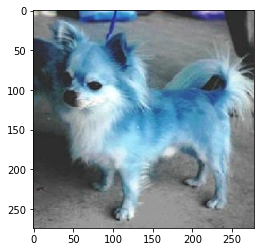

In [118]:
# Define test image
img_test = (images_dir 
            + "/" 
            + "n02085620-Chihuahua/n02085620_1569.jpg")
# lecture d'image
img_test = cv.imread(img_test)
# affichage d' image
plt.imshow(img_test)
# Dimension de l'image
print('Image Dimensions :', img_test.shape)

In [119]:
# Compter le nombre de classes (race de chiens)
race_list = os.listdir(images_dir)
print("Nombre de races dans la base de données:", (len(race_list)))

Nombre de races dans la base de données: 120


In [120]:
print(race_list)

['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfolk_terrier', 'n02094258-Norwich_terrier', 'n02094433-Yorkshire_t

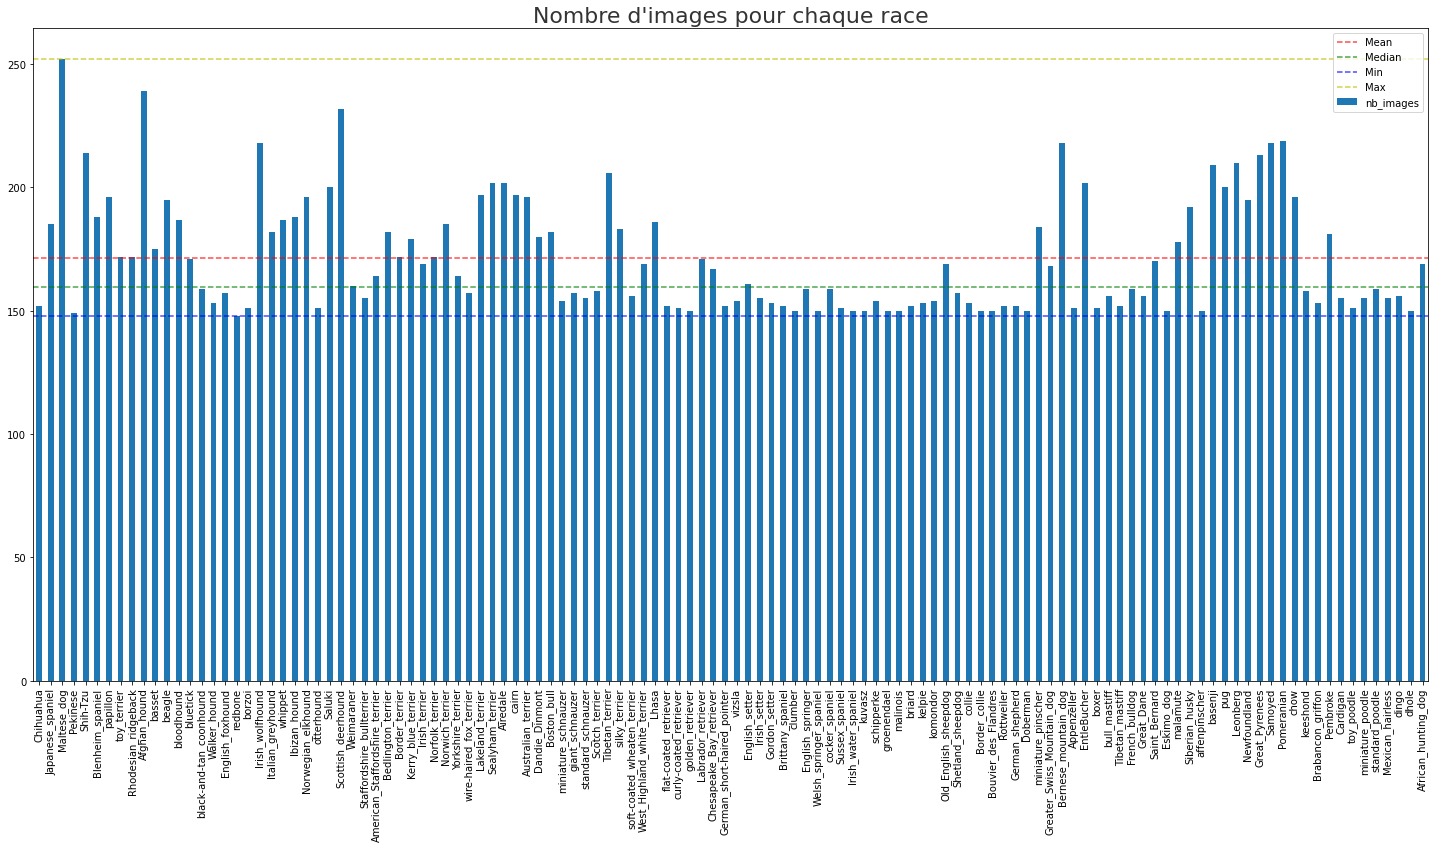

In [121]:
# Comptez le nombre de photos pour chaque race
df_races = pd.DataFrame(
    index=[race.split('-',1)[1]
           for race in race_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in race_list],
    columns=["nb_images"])

# Résultats des tracés
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_races.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_races["nb_images"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean")
ax.axhline(df_races["nb_images"].median(),
           color='g', alpha=.7,
           linestyle='--',
           label="Median")
ax.axhline(df_races["nb_images"].min(),
           color='b', alpha=.7,
           linestyle='--',
           label="Min")
ax.axhline(df_races["nb_images"].max(),
           color='y', alpha=.7,
           linestyle='--',
           label="Max")
plt.title("Nombre d'images pour chaque race",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

In [122]:
print(df_races["nb_images"].mean())

171.5


In [123]:
print(df_races["nb_images"].median())

159.5


In [124]:
print(df_races["nb_images"].min())

148


In [125]:
print(df_races["nb_images"].max())

252


In [126]:
def display_images_classes(path, classes, num_sample):
    """Cette fonction est utilisée pour afficher les 
    n premières images d'un répertoire passé en argument. 
    
    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    plt.suptitle("{}".format(classes.split("-")[1]), y=.9,
                 color="black", fontsize=25)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample, 3, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

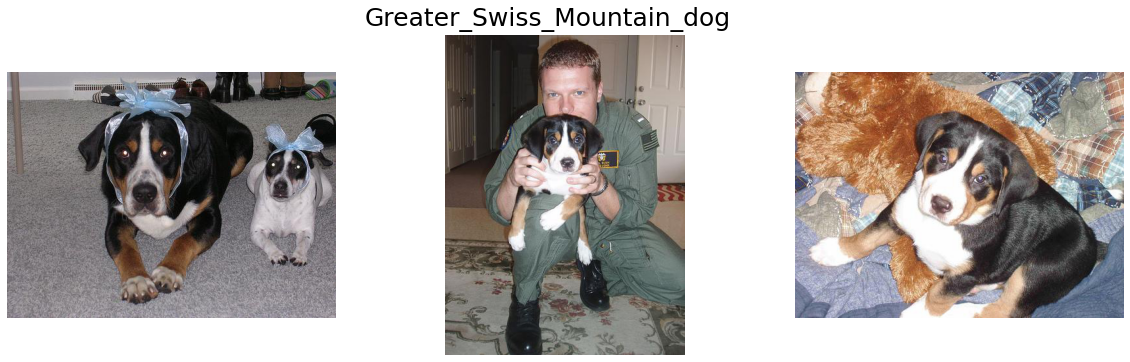

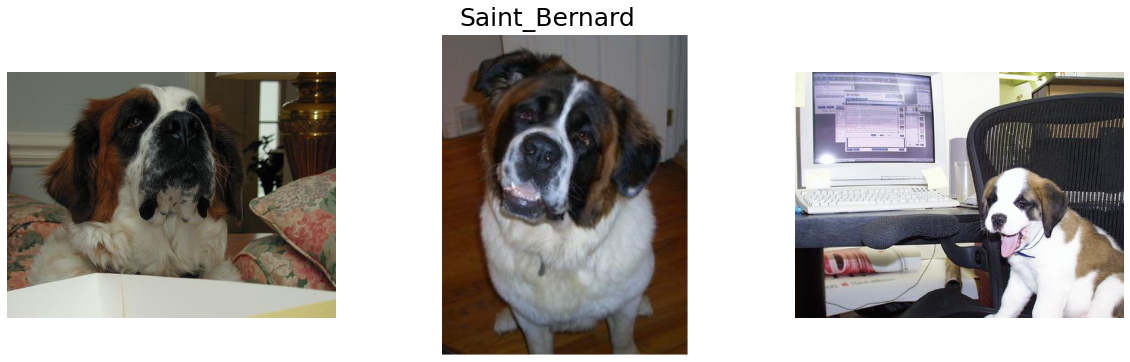

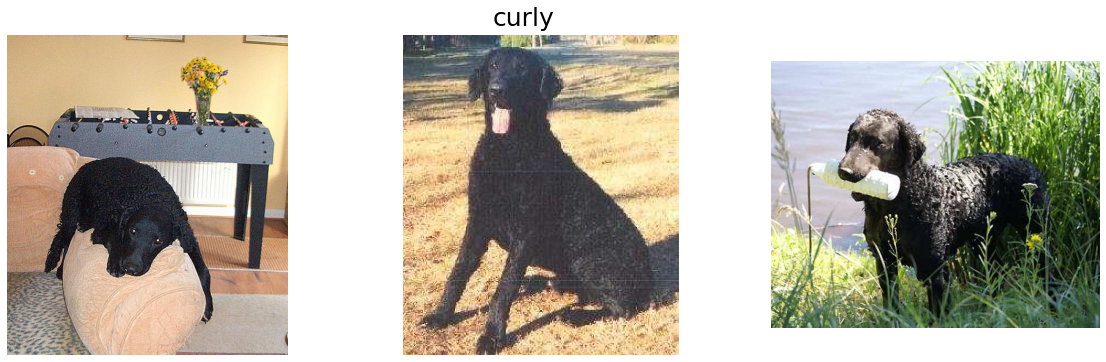

In [145]:
# affichage de 3 images de 3 races
for i in np.random.randint(0, len(race_list), size=3):
    display_images_classes(images_dir, race_list[i], 3)

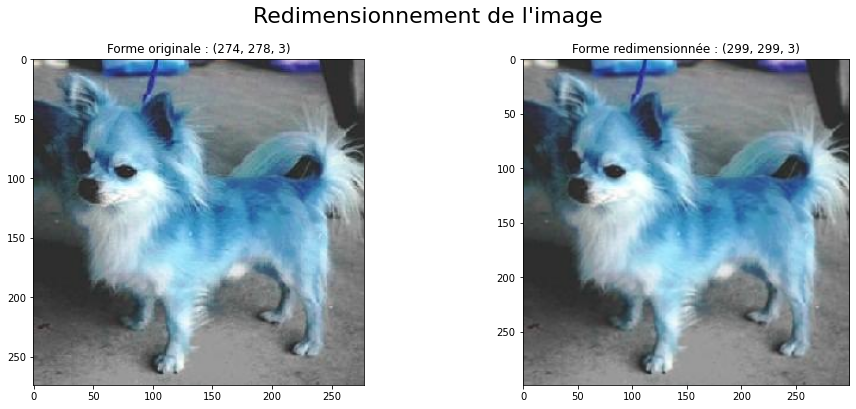

In [128]:
# réglage de la taille du redimensionnement
height = 299
width = 299
dim = (width, height)

# redimensionner l'image avec OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Afficher les deux images
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Forme originale : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Forme redimensionnée : {}".format(res_img.shape))
plt.suptitle("Redimensionnement de l'image",
             color="black", 
             fontsize=22, y=1.)
plt.show()

In [129]:
# Transformer l'image avec différents jeux de couleurs
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

In [130]:
# Créer un histogramme
def plot_histogram(init_img, convert_img):
    """Fonction permettant d'afficher les images initiales
    initiale et convertie selon un certain format
    format colorimétrique ainsi que l'histogramme
    de ces dernières. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Title of the init image
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Title of the converted
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Fonction de distribution cumulative
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogramme de l'image convertie", color="#343434")
    plt.suptitle("Histogramme et distribution cumulative pour l'image de test",
              color="black", fontsize=22, y=.98)
    plt.show()

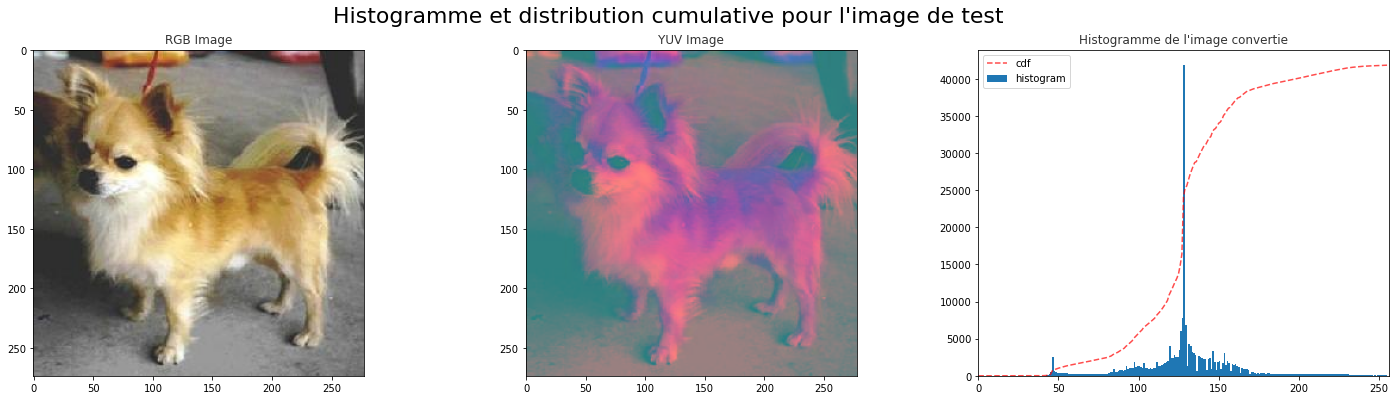

In [131]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

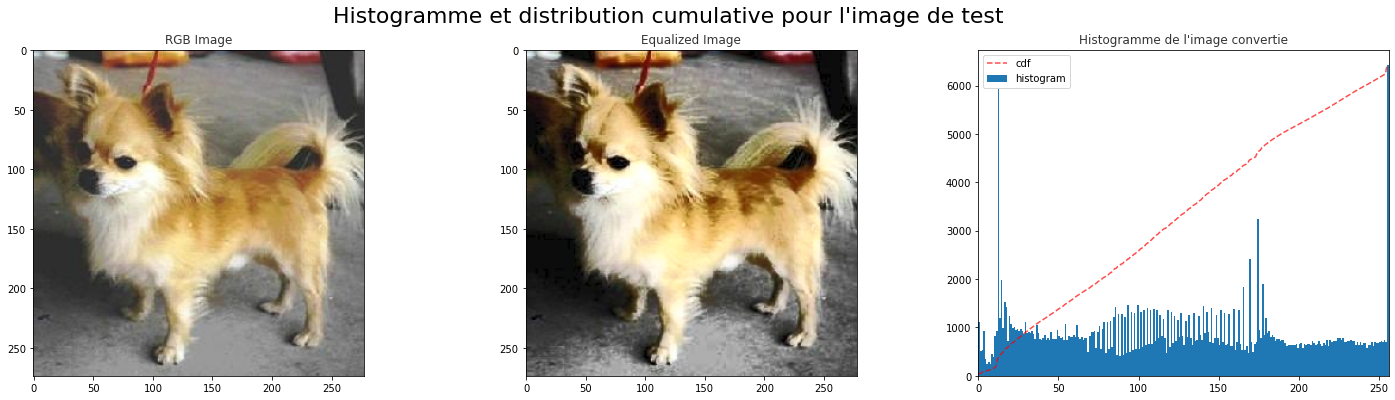

In [132]:
# Egalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

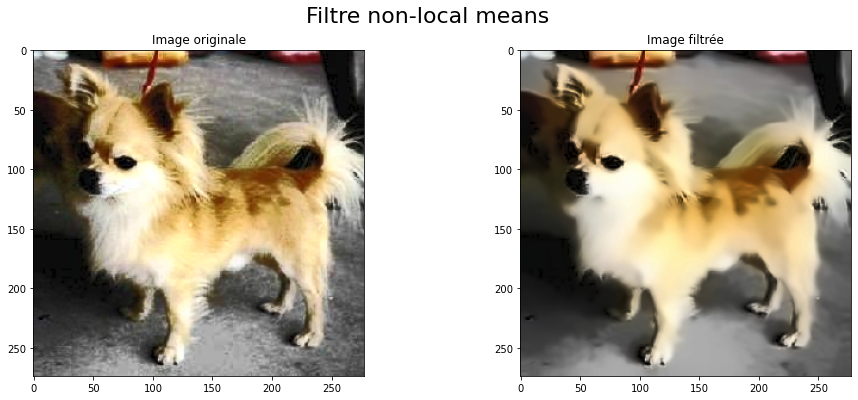

In [133]:
# Appliquer le filtre de moyens non-locaux sur l'image de test
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Afficher les deux images
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Image originale")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Image filtrée")
plt.suptitle("Filtre non-local means",
             color="black", 
             fontsize=22, y=.98)
plt.show()

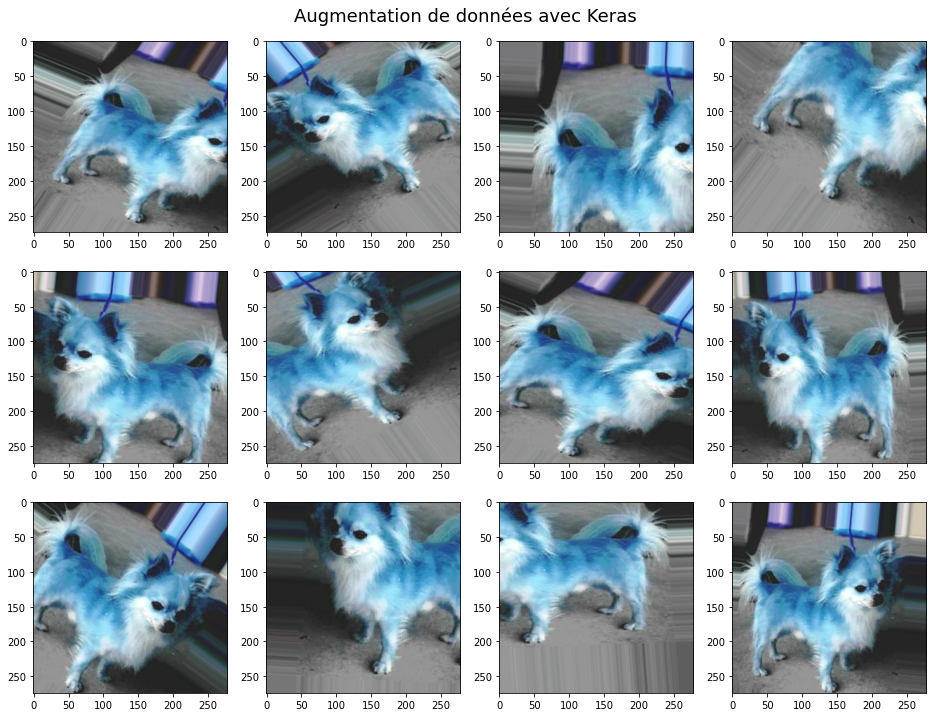

In [134]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

#Initialiser le générateur de données Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convertir le img_test en tableau
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Augmentation de données avec Keras",
             color="black", 
             fontsize=18, y=.92)
plt.show()

In [135]:
def preprocessing_cnn(directories, img_width, img_height):
    """Prétraitement des images en vue de leur intégration 
    dans un réseau de neurones convolutifs. ÉgaliZation, 
    débruitage et transformation de l'image en Array. 
    Création simultanée des étiquettes (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, race in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+race):
            # Lire l'image
            img = cv.imread(images_dir+"/"+race+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Redimensionner l'image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Égalisation
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Appliquer un filtre de moyens non-locaux sur l'image de test
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convertir l'image modifiée en tableau
            img_array = image.img_to_array(dst_img)
            
            # Ajouter des listes d'étiquettes et d'images
            img_list.append(np.array(img_array))
            labels.append(race.split("-")[1])
    
    return img_list, labels

In [23]:
fr_race_list = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02085620-Chihuahua',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog']

In [24]:
# Définir le nombre de races à prétraiter
nb_races = len(fr_race_list) 

# Exécuter le préprocesseur sur la sélection
# X = images
# y = labels
X, y = preprocessing_cnn(fr_race_list, 299, 299)
# Convertir en tableau numpy
X = np.array(X)
y = np.array(y)

print("Nombre d'images prétraitées : {}"\
     .format(len(y)))
print("Forme des images np.array : {}"\
     .format(X.shape))

Nombre d'images prétraitées : 1650
Forme des images np.array : (1650, 299, 299, 3)


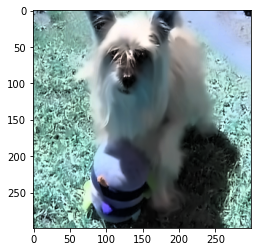

In [25]:
# Afficher un exemple d'image prétraitée
plt.imshow(image.array_to_img(X[1]))

In [26]:
# Utilisation de np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Mélanger l'espace(brassage d'images )
np.random.shuffle(img_space)
# Appliquer à X et y dans le même ordre
X = X[img_space]
y = y[img_space]

In [27]:
from sklearn.preprocessing import LabelEncoder
# Changer le type de X
X = X.astype(np.float32)
# Encoder les données du texte y en numérique
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [28]:
# Vérifier les classes créées par l'encodeur
print(encoder.classes_)

['Australian_terrier' 'Chihuahua' 'English_setter' 'French_bulldog'
 'German_shepherd' 'Labrador_retriever' 'Staffordshire_bullterrier'
 'beagle' 'cocker_spaniel' 'golden_retriever']


In [29]:
from sklearn.model_selection import train_test_split
# Creation train et test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("Train set = ",x_train.shape[0])
print("Test set = ",x_test.shape[0])

Train set =  1320
Test set =  330


In [30]:
# Générateur de données sur le train avec augmentation des données
# Le jeu de validation est défini ici
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

# Pour la validation et le test, il suffit de remettre à l'échelle
test_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

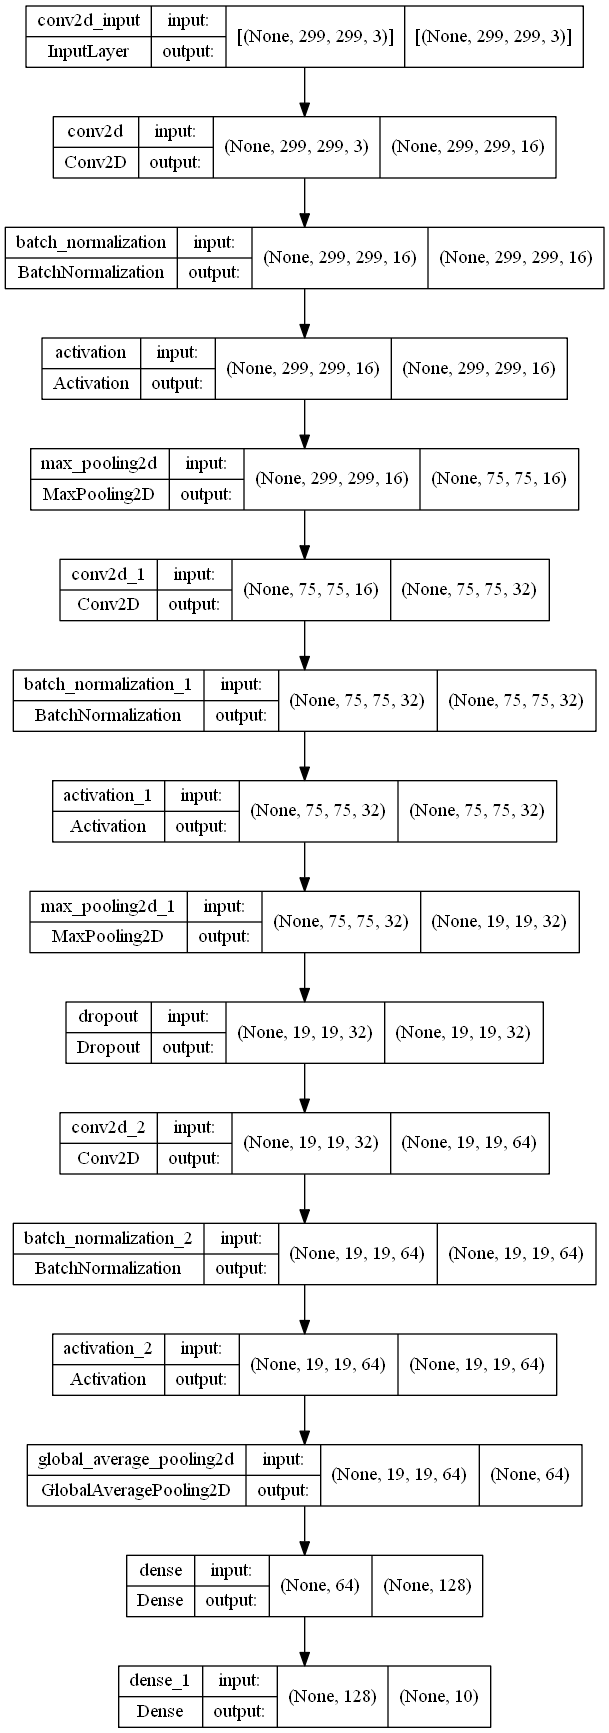

In [32]:
K.clear_session()
model = Sequential()
# Couche de convolution
model.add(Conv2D(filters=16,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False,
                 input_shape=(299,299,3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
# couche de Pooling 
model.add(MaxPooling2D(pool_size=(4, 4),
                       strides=(4, 4),
                       padding='same'))
# Deuxième Couche de convolution
model.add(Conv2D(filters=32,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# Troisième Couche de convolution
model.add(Conv2D(filters=64,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
# Couches Fully connected 
model.add(Dense(128, activation='relu'))
model.add(Dense(nb_races, activation='softmax'))
plot_model(model, to_file='CNN_model_plot.png', 
           show_shapes=True, show_layer_names=True)

In [33]:
# Compilation du modèle CNN
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

In [34]:
#Entrainement et évaluation du modèle CNN
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    verbose=2)


Epoch 1/50
41/41 - 20s - loss: 2.3154 - accuracy: 0.1101 - f1_m: 9.4514 - val_loss: 2.3034 - val_accuracy: 0.0909 - val_f1_m: 10.7073 - 20s/epoch - 486ms/step
Epoch 2/50
41/41 - 19s - loss: 2.2577 - accuracy: 0.1518 - f1_m: 8.9944 - val_loss: 2.3472 - val_accuracy: 0.1212 - val_f1_m: 9.2429 - 19s/epoch - 467ms/step
Epoch 3/50
41/41 - 20s - loss: 2.2372 - accuracy: 0.1696 - f1_m: 8.9711 - val_loss: 2.3387 - val_accuracy: 0.1098 - val_f1_m: 9.5180 - 20s/epoch - 488ms/step
Epoch 4/50
41/41 - 20s - loss: 2.2235 - accuracy: 0.1801 - f1_m: 8.8649 - val_loss: 2.3692 - val_accuracy: 0.1250 - val_f1_m: 8.6542 - 20s/epoch - 494ms/step
Epoch 5/50
41/41 - 22s - loss: 2.2189 - accuracy: 0.1562 - f1_m: 8.6622 - val_loss: 2.4308 - val_accuracy: 0.0947 - val_f1_m: 8.2605 - 22s/epoch - 532ms/step
Epoch 6/50
41/41 - 21s - loss: 2.1811 - accuracy: 0.2039 - f1_m: 8.5317 - val_loss: 2.3248 - val_accuracy: 0.1402 - val_f1_m: 9.2019 - 21s/epoch - 499ms/step
Epoch 7/50
41/41 - 20s - loss: 2.2046 - accuracy: 0

In [35]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="red")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="red")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

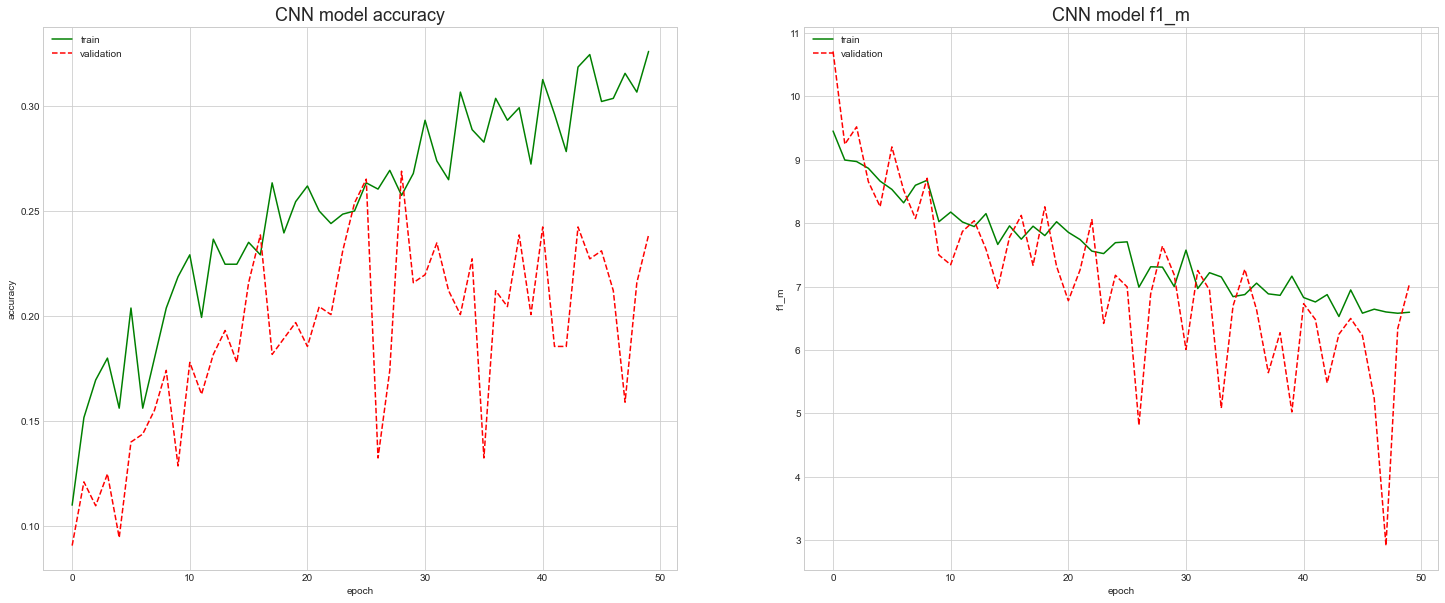

In [36]:
plot_history_scores(
    dict_history = history, 
    first_score = "accuracy", 
    second_score = "f1_m")

In [ ]:
On va tester des modèles pré-entrainés et vérifier si les performances sont meilleures comparées à notre baseline.

In [37]:
K.clear_session()
#Importer le modèle entrainé par Xception
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# les couches
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

--------------------------------------------------
Xception base model layers :
--------------------------------------------------


In [38]:
for layer in xception_model.layers:
    layer.trainable = False

In [39]:
# Ajout de nouvelles couches fully-connected 
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)

# Output : nouveau classifieur
predictions = Dense(nb_races, activation='softmax')(base_output)

# Defition du nouveau modèle
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [40]:
Xception_plot = plot_model(my_xcept_model,
                           to_file='xcept_model_plot.png',
                           show_shapes=True,
                           show_layer_names=False)

In [41]:
# Générateur de données sur le train avec augmentation des données
# et preprocess_input Xception
# Le jeu de validation est défini comme suit
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#Pour la validation et le test, il suffit de remettre à l'échelle
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [43]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    verbose=2)

Epoch 1/50
41/41 - 62s - loss: 1.4057 - accuracy: 0.5655 - f1_m: 4.5454 - val_loss: 0.8593 - val_accuracy: 0.7311 - val_f1_m: 2.4591 - 62s/epoch - 2s/step
Epoch 2/50
41/41 - 63s - loss: 0.7581 - accuracy: 0.7530 - f1_m: 2.1759 - val_loss: 0.6596 - val_accuracy: 0.7689 - val_f1_m: 1.8566 - 63s/epoch - 2s/step
Epoch 3/50
41/41 - 63s - loss: 0.6237 - accuracy: 0.8021 - f1_m: 1.8063 - val_loss: 0.6310 - val_accuracy: 0.7803 - val_f1_m: 1.8979 - 63s/epoch - 2s/step
Epoch 4/50
41/41 - 63s - loss: 0.5659 - accuracy: 0.8214 - f1_m: 1.7158 - val_loss: 0.6354 - val_accuracy: 0.8144 - val_f1_m: 1.7305 - 63s/epoch - 2s/step
Epoch 5/50
41/41 - 64s - loss: 0.5292 - accuracy: 0.8244 - f1_m: 1.6473 - val_loss: 0.5691 - val_accuracy: 0.8144 - val_f1_m: 1.5255 - 64s/epoch - 2s/step
Epoch 6/50
41/41 - 64s - loss: 0.4759 - accuracy: 0.8452 - f1_m: 1.5084 - val_loss: 0.6664 - val_accuracy: 0.7576 - val_f1_m: 1.5738 - 64s/epoch - 2s/step
Epoch 7/50
41/41 - 68s - loss: 0.5162 - accuracy: 0.8318 - f1_m: 1.592

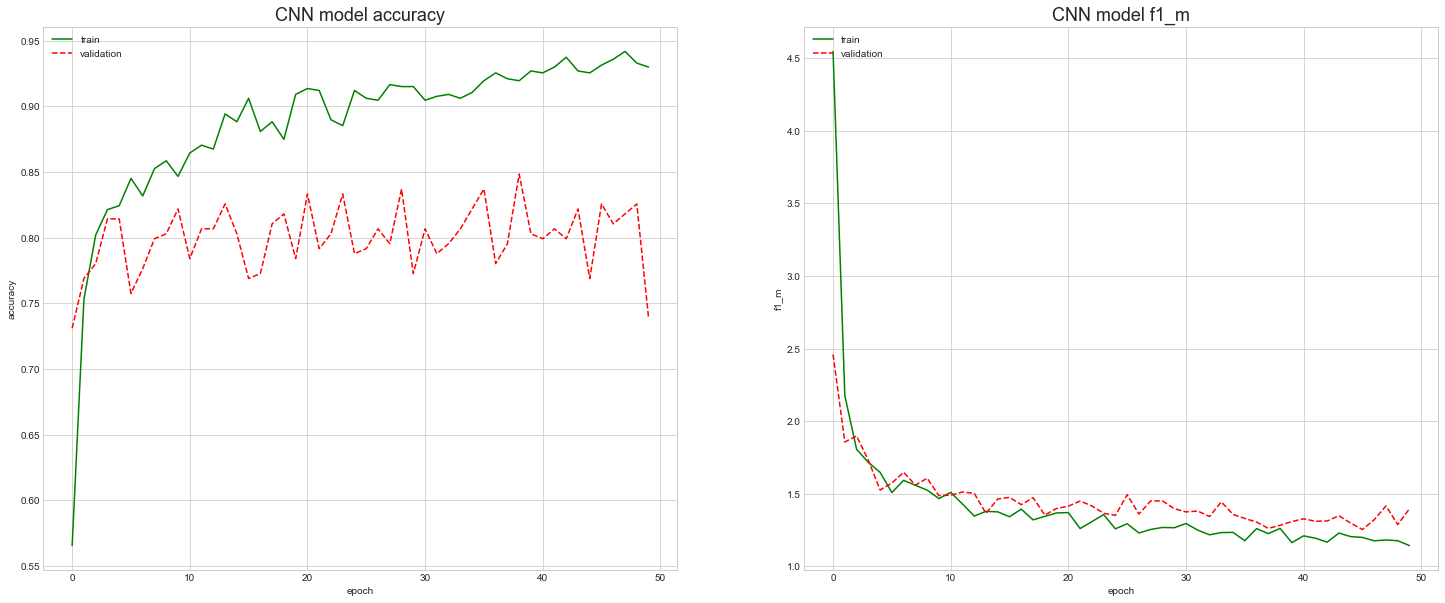

In [44]:
plot_history_scores(
    dict_history = history_xcept, 
    first_score = "accuracy", 
    second_score = "f1_m")

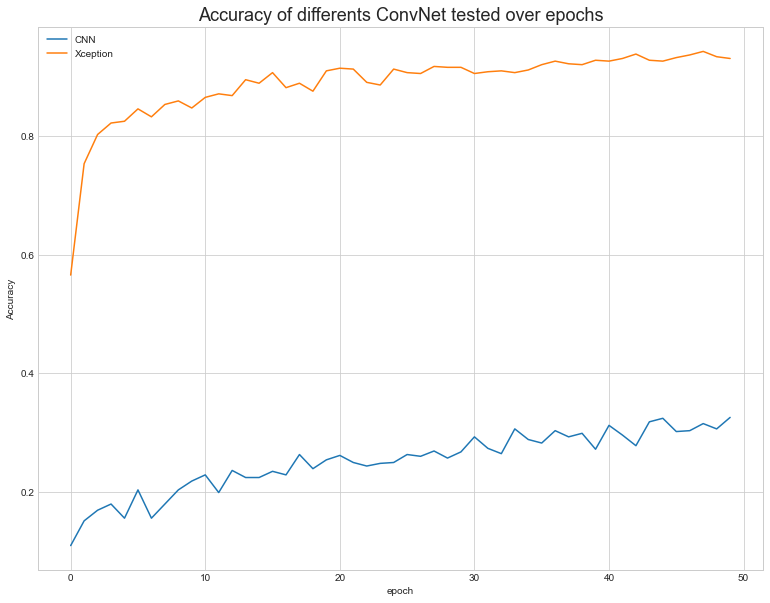

In [45]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN')
    plt.plot(history_xcept.history['accuracy'],
             label='Xception')
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [46]:
xcept_mean_accuracy = np.mean(history_xcept.history['val_accuracy'])
xcept_mean_f1 = np.mean(history_xcept.history['val_f1_m'])
print("-" * 50)
print("Xception base model validation Scores :")
print("-" * 50)
print("Mean validation accuracy: {:.2f}"\
      .format(xcept_mean_accuracy))
print("Mean validation F1 score: {:.2f}"\
      .format(xcept_mean_f1))

--------------------------------------------------
Xception base model validation Scores :
--------------------------------------------------
Mean validation accuracy: 0.80
Mean validation F1 score: 1.45


In [47]:
 K.clear_session()
# Import du modèle entrainé VGG16 
vgg16_model = tf.keras.applications.VGG16(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# ne pas re-entrainer les couches
for rn_layer in vgg16_model.layers:
    rn_layer.trainable = False
    
# Ajout des nouvelles couches fully-connected 
rn_base_output = vgg16_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : nouveau classifier
rn_predictions = Dense(nb_races, activation='softmax')(rn_base_output)

# Definition du nouveau modèle
my_vgg16_model = Model(inputs=vgg16_model.input,
                        outputs=rn_predictions)
my_vgg16_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

#Générateur de données sur le train avec augmentation des données
# et preprocess_input vgg16
# Le jeu de validation est défini comme suit
rn_train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

#Pour la validation et le test, il suffit de remettre à l'échelle
rn_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

In [48]:
history_vgg16 = my_vgg16_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    verbose=2)

Epoch 1/50
41/41 - 145s - loss: 3.9502 - accuracy: 0.1652 - f1_m: 3.0455 - val_loss: 2.1027 - val_accuracy: 0.2614 - val_f1_m: 4.8487 - 145s/epoch - 4s/step
Epoch 2/50
41/41 - 157s - loss: 1.9467 - accuracy: 0.3185 - f1_m: 4.4091 - val_loss: 1.7148 - val_accuracy: 0.3674 - val_f1_m: 4.4398 - 157s/epoch - 4s/step
Epoch 3/50
41/41 - 156s - loss: 1.6476 - accuracy: 0.4405 - f1_m: 4.0193 - val_loss: 1.5821 - val_accuracy: 0.4545 - val_f1_m: 4.0449 - 156s/epoch - 4s/step
Epoch 4/50
41/41 - 160s - loss: 1.5661 - accuracy: 0.4539 - f1_m: 3.3861 - val_loss: 1.5142 - val_accuracy: 0.4659 - val_f1_m: 3.9320 - 160s/epoch - 4s/step
Epoch 5/50
41/41 - 157s - loss: 1.3362 - accuracy: 0.5387 - f1_m: 3.2151 - val_loss: 1.3206 - val_accuracy: 0.5038 - val_f1_m: 3.4737 - 157s/epoch - 4s/step
Epoch 6/50
41/41 - 163s - loss: 1.2286 - accuracy: 0.5744 - f1_m: 2.9371 - val_loss: 1.2816 - val_accuracy: 0.5568 - val_f1_m: 3.1264 - 163s/epoch - 4s/step
Epoch 7/50
41/41 - 161s - loss: 1.1185 - accuracy: 0.6295 

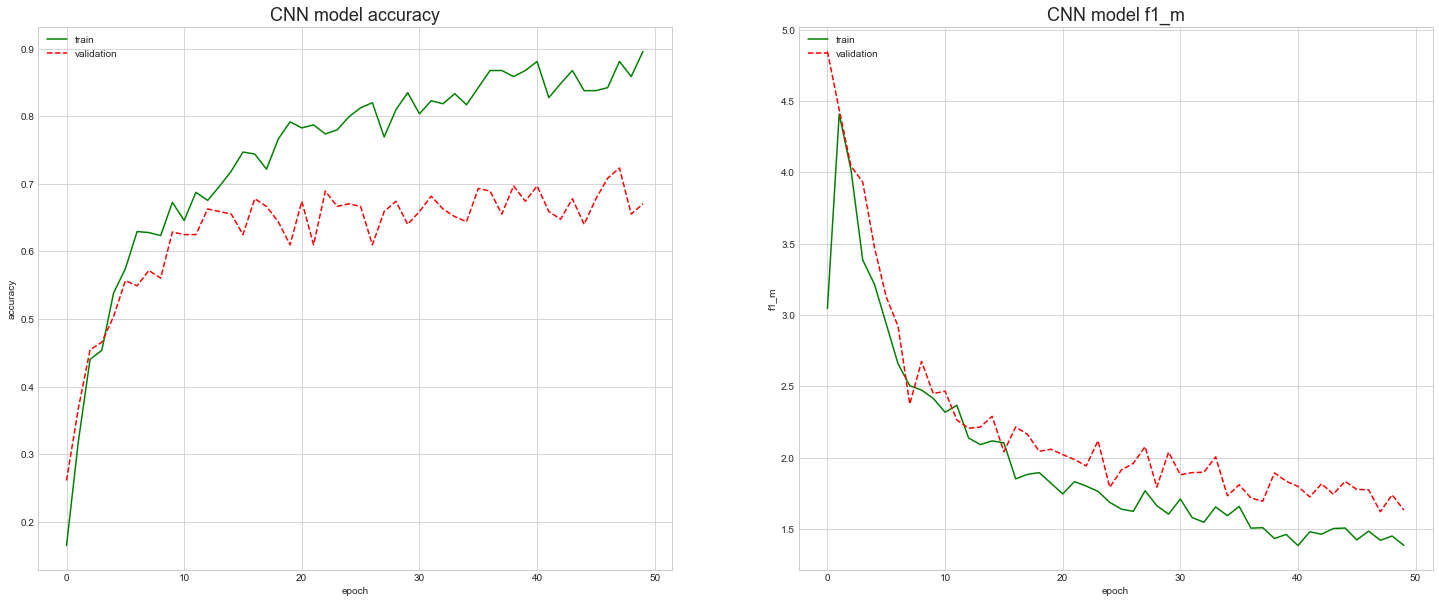

In [49]:
plot_history_scores(
    dict_history = history_vgg16, 
    first_score = "accuracy", 
    second_score = "f1_m")

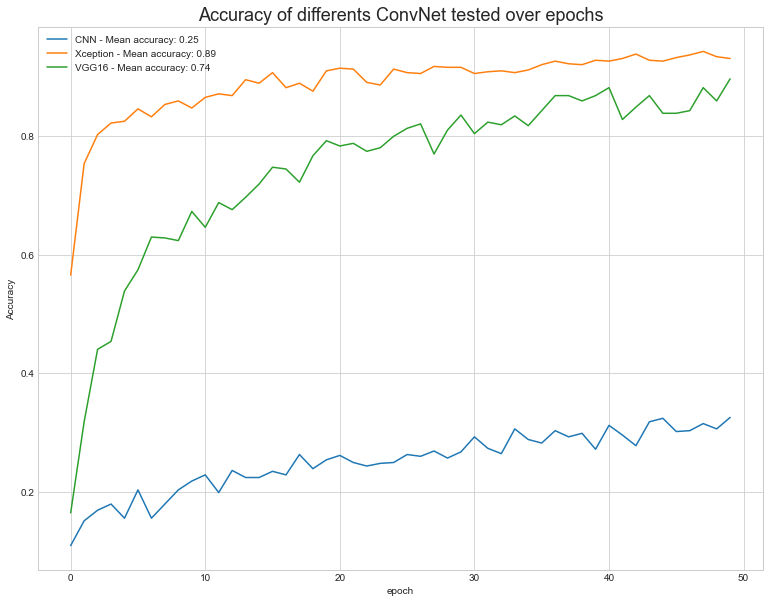

In [50]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_vgg16.history['accuracy'],
             label='VGG16 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_vgg16.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [51]:
 K.clear_session()
# Import du modèle entrainé ResNet50 
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# ne pas re-entrainer les couches
for rn_layer in resnet_model.layers:
    rn_layer.trainable = False
    
# Ajout des nouvelles couches fully-connected 
rn_base_output = resnet_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : nouveau classifier
rn_predictions = Dense(nb_races, activation='softmax')(rn_base_output)

# Definition du nouveau modèle
my_resnet_model = Model(inputs=resnet_model.input,
                        outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

#Générateur de données sur le train avec augmentation des données
# et preprocess_input Resnet
# Le jeu de validation est défini comme suit
rn_train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

#Pour la validation et le test, il suffit de remettre à l'échelle
rn_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

In [52]:
history_resnet = my_resnet_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=50,
    verbose=2)

Epoch 1/50
41/41 - 64s - loss: 2.0511 - accuracy: 0.3333 - f1_m: 5.0732 - val_loss: 1.4989 - val_accuracy: 0.4962 - val_f1_m: 4.5966 - 64s/epoch - 2s/step
Epoch 2/50
41/41 - 64s - loss: 1.3747 - accuracy: 0.5268 - f1_m: 3.7039 - val_loss: 1.1109 - val_accuracy: 0.5947 - val_f1_m: 4.1091 - 64s/epoch - 2s/step
Epoch 3/50
41/41 - 64s - loss: 1.1201 - accuracy: 0.6235 - f1_m: 3.0967 - val_loss: 1.0480 - val_accuracy: 0.6326 - val_f1_m: 3.1437 - 64s/epoch - 2s/step
Epoch 4/50
41/41 - 64s - loss: 0.9790 - accuracy: 0.6518 - f1_m: 2.6068 - val_loss: 1.0153 - val_accuracy: 0.6553 - val_f1_m: 2.9405 - 64s/epoch - 2s/step
Epoch 5/50
41/41 - 65s - loss: 0.9066 - accuracy: 0.6920 - f1_m: 2.4709 - val_loss: 1.0507 - val_accuracy: 0.6439 - val_f1_m: 2.5999 - 65s/epoch - 2s/step
Epoch 6/50
41/41 - 64s - loss: 0.7951 - accuracy: 0.7202 - f1_m: 2.1279 - val_loss: 0.8900 - val_accuracy: 0.6818 - val_f1_m: 2.4883 - 64s/epoch - 2s/step
Epoch 7/50
41/41 - 64s - loss: 0.7401 - accuracy: 0.7530 - f1_m: 2.122

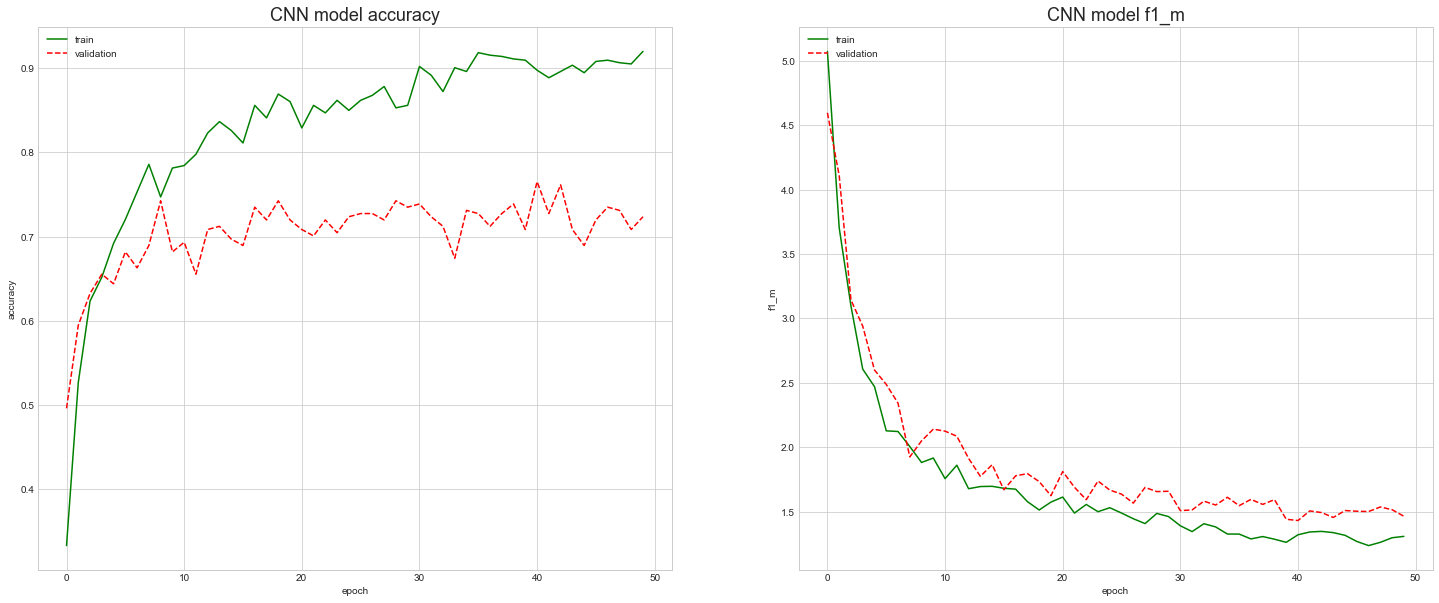

In [53]:
plot_history_scores(
    dict_history = history_resnet, 
    first_score = "accuracy", 
    second_score = "f1_m")

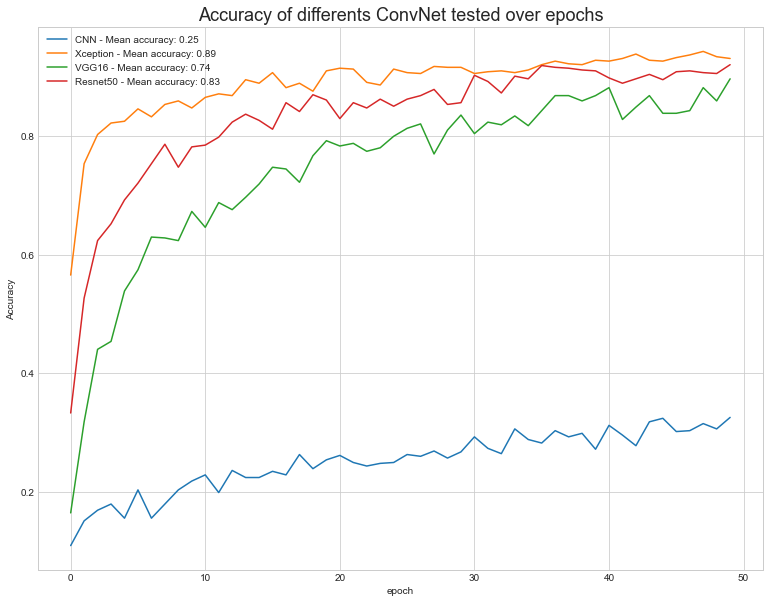

In [54]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_vgg16.history['accuracy'],
             label='VGG16 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_vgg16.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [66]:
def model_builder(hp):
    # charger le modèle de base
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(299,299,3))
    
    for layer in xception_model.layers:
        layer.trainable = False
    
    base_output = xception_model.output
    
    # Accorder les unités denses
    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)

    base_output = Dense(units=hp_units, 
                        activation='relu')(base_output)
    
    base_output = Dropout(0.2)(base_output)
    
    # Output : nouveau classifier
    predictions = Dense(nb_races, activation='softmax')(base_output)

    # Definition du nouveau modèle
    my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
    
    # Régler le taux d'apprentissage
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4])

    my_xcept_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return my_xcept_model

In [67]:
# Régler le taux d'apprentissage de l'optimiseur
# Construire le tuner de keras_tuner
tuner = kt.RandomSearch(
    model_builder, 
    objective='val_accuracy',
    max_trials=5)

# Définir un arrêt précoce
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Recherche des meilleurs paramètres
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    epochs=10,
    callbacks=[stop_early])

# Obtenir les hyperparamètres optimaux
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("Xception Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps.get('learning_rate')}.\n
Best Dense units : {best_hps.get('dense_units')}.""")

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit
--------------------------------------------------
Xception Hyperparameters optimization :
--------------------------------------------------

Best learning rate : 0.001.

Best Dense units : 96.


In [68]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'), 
    epochs=50,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    verbose=2)
hypermodel.save('xception_hypermodel.h5')
print("Model saved")

Epoch 1/50
66/66 - 86s - loss: 1.2302 - accuracy: 0.6117 - f1_m: 4.1799 - val_loss: 0.6932 - val_accuracy: 0.7955 - val_f1_m: 2.2561 - 86s/epoch - 1s/step
Epoch 2/50
66/66 - 87s - loss: 0.6918 - accuracy: 0.7784 - f1_m: 1.9722 - val_loss: 0.5951 - val_accuracy: 0.7992 - val_f1_m: 1.8246 - 87s/epoch - 1s/step
Epoch 3/50
66/66 - 88s - loss: 0.5854 - accuracy: 0.8125 - f1_m: 1.7694 - val_loss: 0.5672 - val_accuracy: 0.8220 - val_f1_m: 1.6302 - 88s/epoch - 1s/step
Epoch 4/50
66/66 - 88s - loss: 0.5416 - accuracy: 0.8229 - f1_m: 1.6674 - val_loss: 0.6040 - val_accuracy: 0.7803 - val_f1_m: 1.6416 - 88s/epoch - 1s/step
Epoch 5/50
66/66 - 87s - loss: 0.4614 - accuracy: 0.8504 - f1_m: 1.5629 - val_loss: 0.6811 - val_accuracy: 0.7765 - val_f1_m: 1.5995 - 87s/epoch - 1s/step
Epoch 6/50
66/66 - 88s - loss: 0.4683 - accuracy: 0.8438 - f1_m: 1.5461 - val_loss: 0.6567 - val_accuracy: 0.7917 - val_f1_m: 1.6507 - 88s/epoch - 1s/step
Epoch 7/50
66/66 - 88s - loss: 0.3998 - accuracy: 0.8646 - f1_m: 1.499

C:\Users\Admin\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Model saved


In [69]:
def xception_fine_tune(nb_layers):
    # Charger le modèle pré-entraîné
    hypermodel_t = load_model('./xception_hypermodel.h5', custom_objects={"f1_m": f1_m})
    
    # ré-entraîner les dernières couches
    for i, layer in enumerate(hypermodel_t.layers):
        if i < nb_layers:
            layer.trainable = False
        else:
            layer.trainable = True
            
    # Compiler le modèle
    hypermodel_t.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return hypermodel_t

In [70]:
# Définir un arrêt précoce
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Ne pas former les 115 premières couches
my_tuned_xcept_model = xception_fine_tune(115)
fine_tuned_history = my_tuned_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='training'), 
    epochs=50,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='validation'),
    callbacks=[stop_early],
    verbose=2)

Epoch 1/50
66/66 - 113s - loss: 0.9549 - accuracy: 0.7027 - f1_m: 2.0305 - val_loss: 2.2369 - val_accuracy: 0.6629 - val_f1_m: 1.3003 - 113s/epoch - 2s/step
Epoch 2/50
66/66 - 120s - loss: 0.6811 - accuracy: 0.7973 - f1_m: 1.6991 - val_loss: 1.0962 - val_accuracy: 0.6780 - val_f1_m: 1.4484 - 120s/epoch - 2s/step
Epoch 3/50
66/66 - 125s - loss: 0.4755 - accuracy: 0.8400 - f1_m: 1.4504 - val_loss: 0.7880 - val_accuracy: 0.7576 - val_f1_m: 1.4137 - 125s/epoch - 2s/step
Epoch 4/50
66/66 - 125s - loss: 0.2902 - accuracy: 0.9025 - f1_m: 1.2371 - val_loss: 0.9514 - val_accuracy: 0.7462 - val_f1_m: 1.3470 - 125s/epoch - 2s/step
Epoch 5/50
66/66 - 123s - loss: 0.3363 - accuracy: 0.8902 - f1_m: 1.2416 - val_loss: 0.8490 - val_accuracy: 0.7538 - val_f1_m: 1.4965 - 123s/epoch - 2s/step
Epoch 6/50
66/66 - 122s - loss: 0.2572 - accuracy: 0.9186 - f1_m: 1.1711 - val_loss: 1.1984 - val_accuracy: 0.7424 - val_f1_m: 1.2353 - 122s/epoch - 2s/step
Epoch 7/50
66/66 - 130s - loss: 0.2573 - accuracy: 0.9186 

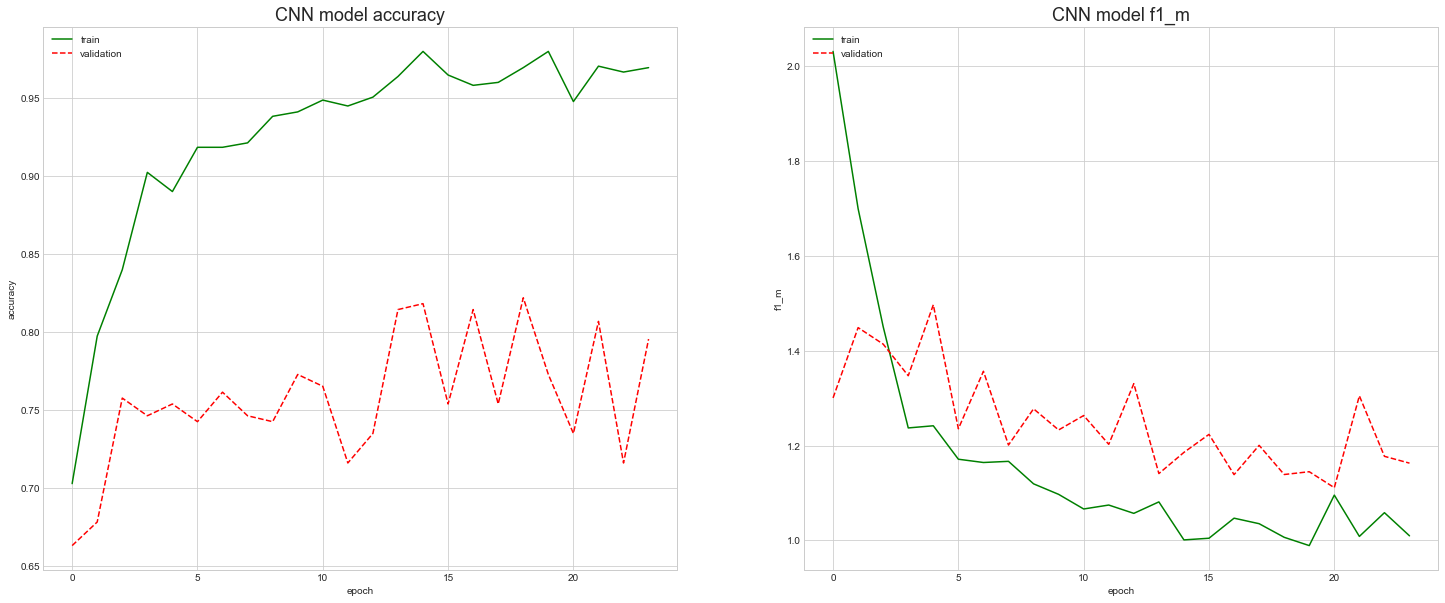

In [71]:
plot_history_scores(
    dict_history = fine_tuned_history, 
    first_score = "accuracy", 
    second_score = "f1_m")

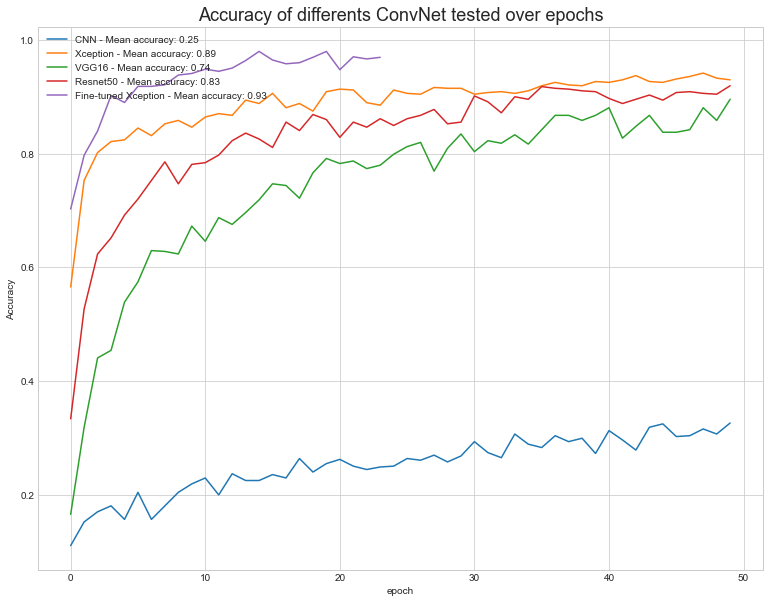

In [72]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_vgg16.history['accuracy'],
             label='VGG16 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_vgg16.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.plot(fine_tuned_history.history['accuracy'],
             label='Fine-tuned Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(fine_tuned_history.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [73]:
# Évaluation du modèle sur l'ensemble de test
xception_eval = fine_tuned_history.model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print("-" * 50)
print("Évaluation du modèle Xception :")
print("-" * 50)
print('Test Loss: {:.3f}'.format(xception_eval[0]))
print('Test Accuracy: {:.3f}'.format(xception_eval[1]))
print('Test F1 score: {:.3f}'.format(xception_eval[2]))

21/21 [==============================] - 27s 1s/step - loss: 1.1995 - accuracy: 0.8061 - f1_m: 1.0778
--------------------------------------------------
Xception model evaluation :
--------------------------------------------------
Test Loss: 1.199
Test Accuracy: 0.806
Test F1 score: 1.078


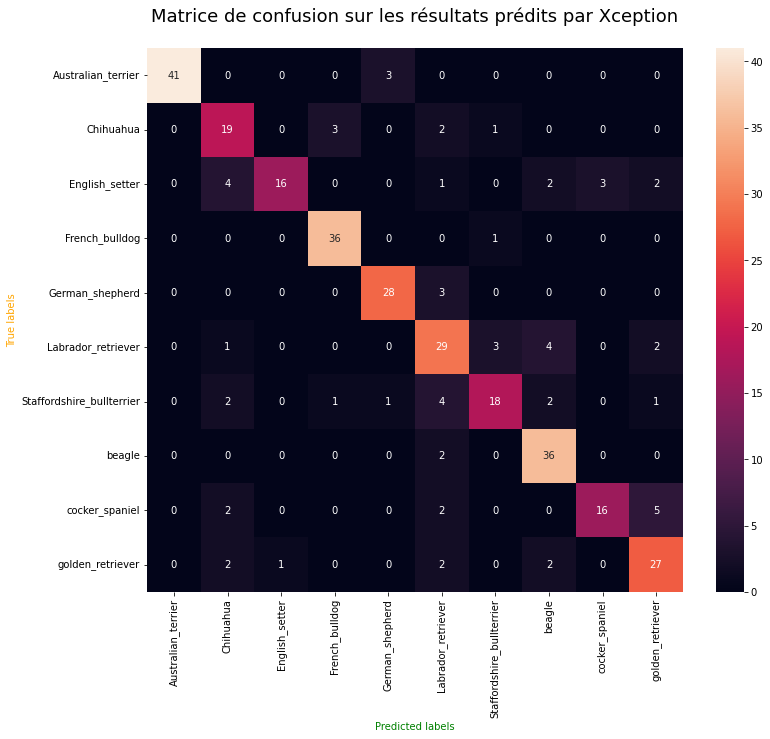

In [143]:
# les predictions
Y_pred = fine_tuned_history.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

# Transformation inverse de l'encodage
y_pred_s = encoder.inverse_transform(y_pred)
y_test_s = encoder.inverse_transform(y_test)

# Matrice de confusion
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("Predicted labels")
ax.set_ylabel("True labels")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Matrice de confusion sur les résultats prédits par Xception\n",
          fontsize=18)
plt.show()

In [75]:
# Rapport de classification
print(classification_report(
    y_test, y_pred, 
    target_names=sorted(set(y_test_s))))

                           precision    recall  f1-score   support

       Australian_terrier       1.00      0.93      0.96        44
                Chihuahua       0.63      0.76      0.69        25
           English_setter       0.94      0.57      0.71        28
           French_bulldog       0.90      0.97      0.94        37
          German_shepherd       0.88      0.90      0.89        31
       Labrador_retriever       0.64      0.74      0.69        39
Staffordshire_bullterrier       0.78      0.62      0.69        29
                   beagle       0.78      0.95      0.86        38
           cocker_spaniel       0.84      0.64      0.73        25
         golden_retriever       0.73      0.79      0.76        34

                 accuracy                           0.81       330
                macro avg       0.81      0.79      0.79       330
             weighted avg       0.82      0.81      0.80       330



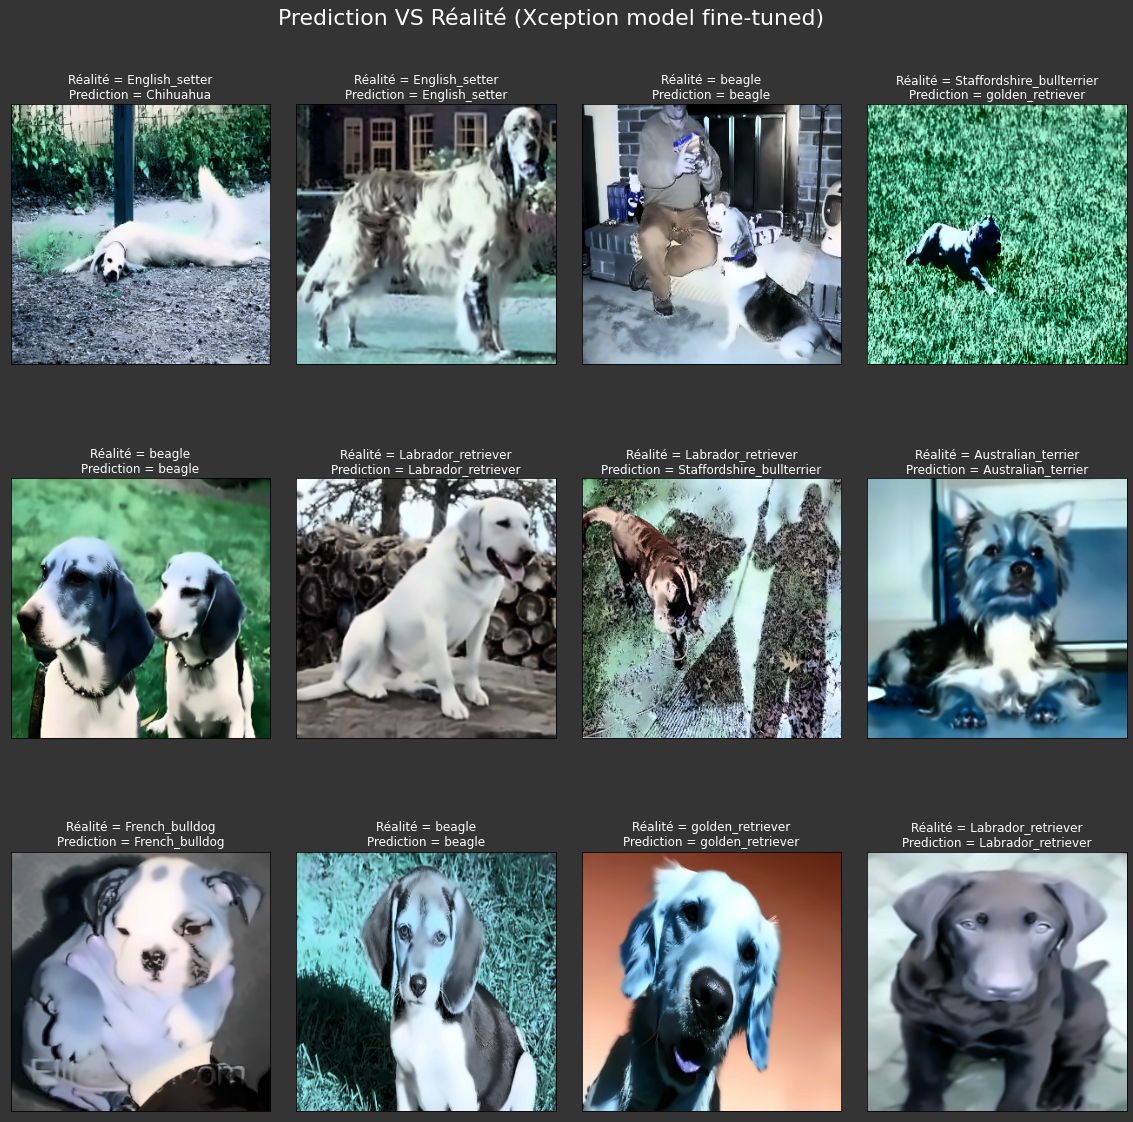

In [140]:
fig = plt.figure(1, figsize=(20,20))
fig.patch.set_facecolor('#343434')
plt.suptitle("Prediction VS Réalité (Xception model fine-tuned)",
             y=.92, fontsize=22,
             color="white")

n = 0

for i in range(12):
    n+=1
    r = int(np.random.randint(0, x_test.shape[0], 1))
    plt.subplot(3,4,n)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(image.array_to_img(x_test[r]))
    plt.title('Réalité = {}\nPrediction = {}'.format(y_test_s[r] , y_pred_s[r]),
              color="white")
    plt.xticks([]) , plt.yticks([])
    
plt.show()

In [86]:
# Sauvegarder le dernier modèle
fine_tuned_history.model.save('xception_trained_model.h5')
print("Last model saved")

Last model saved


C:\Users\Admin\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
